# Geometry computations: Example 1

<span style="color:black; font-family:Poppins; font-size:1.5em;">

Here we
* (1) Divide the experimental arena into geometries, and 
* (2) Compute and visualize the time that the animal spends in the different arena geometries.
   </span>

In [1]:
import numpy as np
import os
import cv2
from simba.mixins.geometry_mixin import GeometryMixin
from simba.mixins.config_reader import ConfigReader
from simba.utils.read_write import read_df, read_frm_of_video
from simba.mixins.plotting_mixin import PlottingMixin
import matplotlib.pyplot as plt
import matplotlib 
dpi = matplotlib.rcParams['figure.dpi']

In [2]:
# DEFINE PROJECT AND VIDEO NAME
PROJECT_PATH = r'/Users/simon/Desktop/envs/troubleshooting/Rat_NOR/project_folder/project_config.ini'
VIDEO_NAME = '2022-06-20_NOB_DOT_4'
BP = 'Nose' # THE BODY-PART WE WILL USE TO INFER POSITION OF ANIMAL

In [3]:
# READ IN THE DATA, VIDEO SIZE, FPS, AND PIXEL CONVERSION FACTOR.
config = ConfigReader(config_path=PROJECT_PATH, create_logger=False)
video_info, px_per_mm, fps = config.read_video_info(video_name=VIDEO_NAME)
width, height = int(video_info['Resolution_width'].values[0]), int(video_info['Resolution_height'].values[0])
bp = [f'{BP}_x', f'{BP}_y']
data_path = os.path.join(config.outlier_corrected_dir, VIDEO_NAME + f'.{config.file_type}')
data = read_df(file_path=data_path, usecols=bp, file_type=config.file_type)

In [4]:
# WE CREATE A SQUARE GEOMETRY GRID WHICH IS 5 BY 5 LARGE TO COVER THE EXPERIMENTAL ARENA
GRID_SIZE = (5, 5) # THE SIXE OF THE GRID WE WILL CREATE
grid, aspect_ratio = GeometryMixin().bucket_img_into_grid_square(img_size=(width, height), bucket_grid_size=GRID_SIZE, px_per_mm=px_per_mm)

SIMBA COMPLETE: Bucket image into grid squares complete (elapsed time: 0.0004s) 	complete


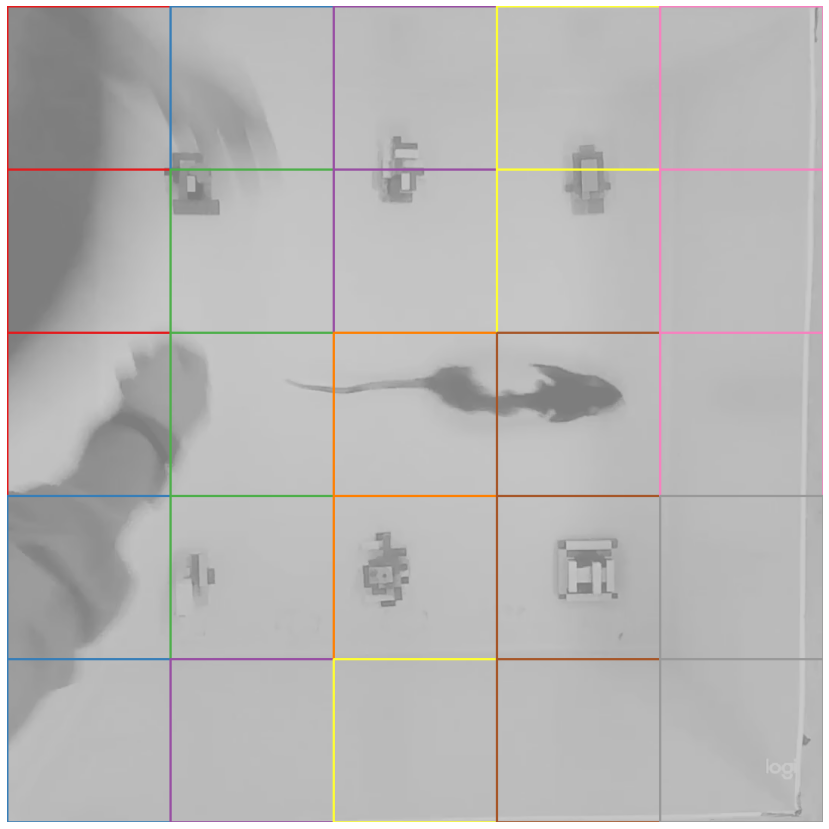

In [5]:
# WE VISUALIZE THE GRID AS A SANITY CHECK 
video_path = r'/Users/simon/Desktop/envs/troubleshooting/Rat_NOR/project_folder/videos/2022-06-20_NOB_DOT_4.mp4'
video_frm = read_frm_of_video(video_path=video_path, frame_index=0, opacity=30)
img = GeometryMixin().view_shapes(shapes=list(grid.values()), bg_img=video_frm)
height, width, depth = img.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()

SIMBA COMPLETE: Bucket image into hexagon grid complete (elapsed time: 0.0059s) 	complete


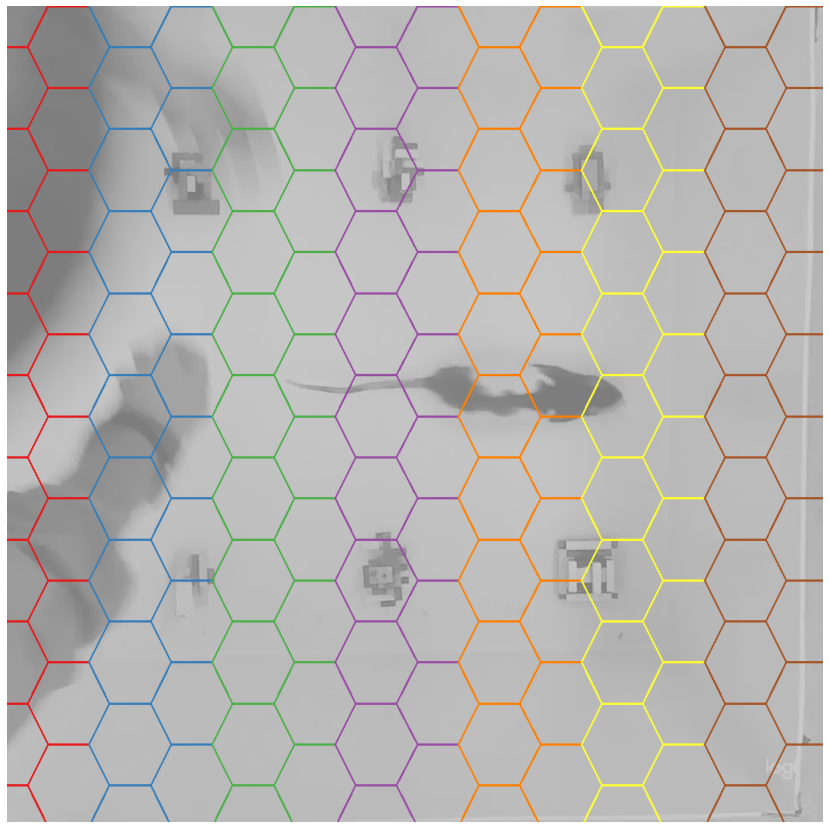

In [6]:
# ALTERNATIVE: IF YOU PREFER HEXAGONAL GRID, USE simba.mixins.geometry_mixins.GeometryMixin.bucket_img_into_grid_hexagon()
hex_grid, aspect_ratio = GeometryMixin().bucket_img_into_grid_hexagon(img_size=(width, height), bucket_size_mm=20, px_per_mm=px_per_mm)
video_frm = read_frm_of_video(video_path=video_path, frame_index=0, opacity=30)
img = GeometryMixin().view_shapes(shapes=list(hex_grid.values()), bg_img=video_frm)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()

SIMBA COMPLETE: Bucket image into grid points complete (elapsed time: 0.0089s) 	complete


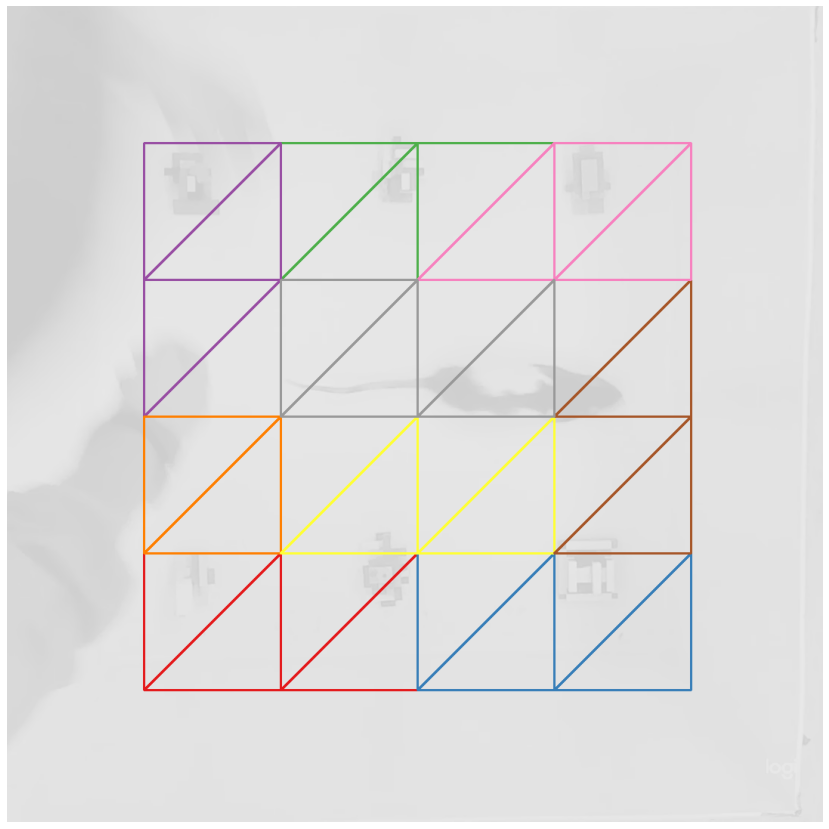

In [7]:
# ALTERNATIVE: IF YOU PREFER TRIANGULATES GRID, USE simba.mixins.geometry_mixins.GeometryMixin.delaunay_triangulate_keypoints()
grid_points = GeometryMixin().bucket_img_into_grid_points(point_distance=100, px_per_mm=px_per_mm, img_size=(width, height), border_sites= False)
grid_point_locations = np.full((len(list(grid_points.keys()), ), 2), np.nan)
for cnt, (k, v) in enumerate(grid_points.items()): grid_point_locations[cnt] = np.array(v)
delaunay_grid = GeometryMixin().delaunay_triangulate_keypoints(data=grid_point_locations)

video_frm = read_frm_of_video(video_path=video_path, frame_index=0, opacity=10)
img = GeometryMixin().view_shapes(shapes=delaunay_grid, bg_img=video_frm)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()

In [8]:
# WE CALCULATE THE CUMULATIVE TIME THE ANIMAL SPENDS IN EACH GEOMETRY
time_data = GeometryMixin().cumsum_coord_geometries(data=data.values, geometries=grid, fps=fps, verbose=False)

SIMBA COMPLETE: Cumulative coordinates in geometries complete (elapsed time: 5.0678s) 	complete


In [9]:
#THIS RETURNS A 3D ARRAY, WHERE THE LAST 2D ARRAY CORRESPONDS WITH THE CUMULATIVE TIME THE ANIMAL HAS SPENT IN
#EACH GEOMETRY AT THE END OF THE VIDEO.

#EACH 2D ARRAY REPRESENTS THE CUMULATIVE TIME THE ANIMAL HAS SPENT IN EACH GEOMETRY UP UNTIL AND INCLUDING THAT FRMAE,
#AND THE ARRAY WILL BE LEN(VIDEO FRAMES) X VERTICAL SHAPES X HORIXONTAL SHAPES. 
time_data[-1]

array([[11.36666667, 26.93333333, 41.06666667,  7.86666667,  5.46666667],
       [ 7.16666667, 14.53333333, 27.7       ,  6.86666667,  8.86666667],
       [18.96666667, 19.46666667, 25.16666667,  2.06666667, 11.4       ],
       [ 0.76666667,  2.26666667,  1.5       ,  0.        ,  3.26666667],
       [ 7.83333333, 17.83333333, 14.9       ,  9.2       ,  7.53333333]])

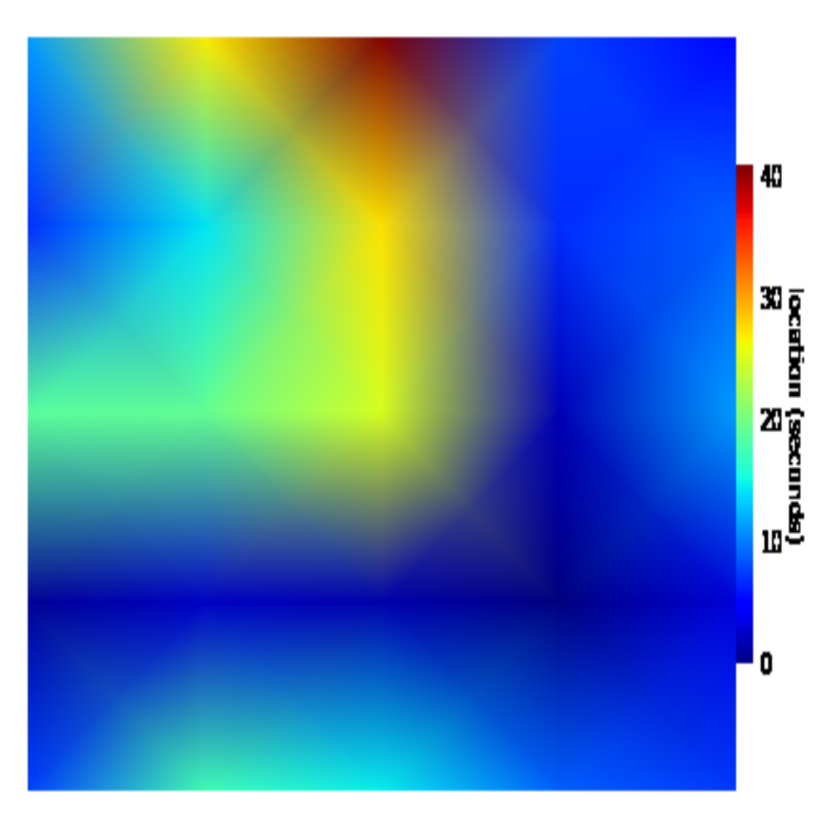

In [10]:
#TO PLOT A HEATMAP REPRESENTING THE GRID LOCATIONS OF THE ANIMAL IN THE VIDEO, USE 
# simba.mixins.plotting_mixin.PlottingMixin.make_location_heatmap_plot()

img = PlottingMixin().make_location_heatmap_plot(frm_data=time_data[-1],
                                                 max_scale=np.max(time_data[-1]),
                                                 palette='jet',
                                                 shading='gouraud',
                                                 img_size=(width, height),
                                                 aspect_ratio=aspect_ratio)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, depth = img.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()

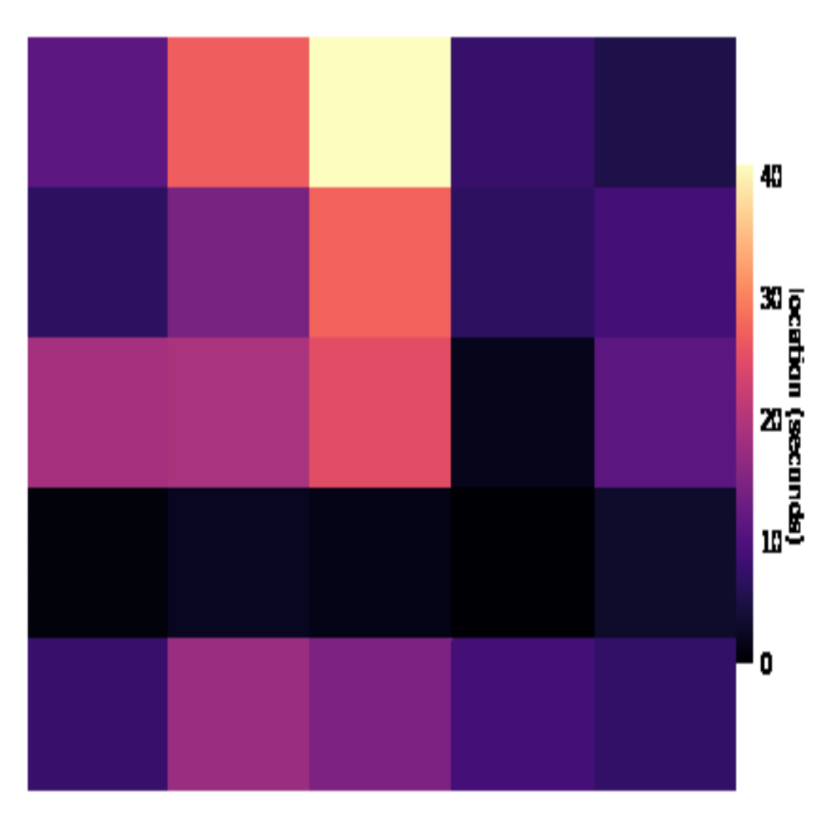

In [11]:
# ALTERNATIVE EXAMPLE USING FLAT AND MAGMA SETTINGS
img = PlottingMixin().make_location_heatmap_plot(frm_data=time_data[-1],
                                                 max_scale=np.max(time_data[-1]),
                                                 palette='magma',
                                                 shading='flat',
                                                 img_size=(width, height),
                                                 aspect_ratio=aspect_ratio)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, depth = img.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()